## Imports

In [1]:
import vizdoom as vzd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import cv2
from collections import deque
import random

## Variables and helper functions

In [2]:
# global variables
config_file = "defend_the_center.cfg"

#dqn parameters
l_r = 0.001
batch_size = 50
episodes_per_epoch = 100
epochs = 50

# input parameters
input_shape = (100, 100)
replay_buffer_size = 500

#game parameters
frames_to_skip = 10
discount = 0.9

# helper functions
def display_image(image):
    plt.imshow(image, cmap='gray')

def process_raw_input(image):
    return cv2.resize(image, input_shape).reshape((*input_shape, 1))

## Initialize doom

In [3]:
def initialize_game(visible=False):
    game = vzd.DoomGame()
    game.load_config("../../scenarios/" + config_file)
    game.set_window_visible(visible)
    game.set_mode(vzd.Mode.PLAYER)
    game.set_screen_format(vzd.ScreenFormat.GRAY8)
    game.set_screen_resolution(vzd.ScreenResolution.RES_1280X1024)
    game.init()
    return game

## DQN

In [4]:
class DQN():
    def __init__(self, num_actions):
        self.graph = tf.Graph()
        with self.graph.as_default(): 
            self._X = tf.placeholder(tf.float32, [None] + list(input_shape) + [1], name="X")
    #         a_ = tf.placeholder(tf.int32, [None], name="Action")
            self._y = tf.placeholder(tf.float32, [None, num_actions], name="y_true")

            # convolutional layers
            self._conv1 = tf.layers.conv2d(
                                inputs=self._X,
                                filters=8,
                                kernel_size=[9, 9],
                                strides=[2, 2],
                                activation=tf.nn.relu,
                                name="conv1")
            self._pool1 = tf.layers.max_pooling2d(inputs=self._conv1, pool_size=[2, 2], strides=2, name="pool1")

            self._conv2 = tf.layers.conv2d(
                                inputs=self._pool1,
                                filters=32,
                                kernel_size=[5, 5],
                                strides=[2, 2],
                                activation=tf.nn.relu,
                                name="conv2", )
            self._pool2 = tf.layers.max_pooling2d(inputs=self._conv2, pool_size=[2, 2], strides=2, name="pool2")

            #fcn
            self._flat = tf.layers.flatten(self._pool2, name="flat")
            self._fc1 = tf.layers.dense(inputs=self._flat, units=512, activation=tf.nn.relu, name="fc1", )
            self._dropout = tf.layers.dropout(inputs=self._fc1, rate=0.5, name="dropout")

            self._y_pred = tf.layers.dense(inputs=self._dropout, units=num_actions, name="y_pred", )

            #train
            self._loss = tf.losses.mean_squared_error(labels=self._y, predictions=self._y_pred)
            self._optimizer = tf.train.AdamOptimizer(learning_rate=l_r).minimize(self._loss)
            self._session = tf.Session(graph=self.graph)
            self._session.run(tf.global_variables_initializer())

    def train(self, X, y):
        with self.graph.as_default():
            loss, _ = self._session.run([self._loss, self._optimizer], feed_dict={self._X: X, self._y: y})
        return loss
    
    def get_q_values(self, state):
        return self._session.run(self._y_pred, feed_dict={self._X: state})
    
    def get_best_action(self, state):
        return self.get_q_values(state).argmax()
    
    def finish(self):
        self._session.close()
    
    def save_model(self, path):
        with self.graph.as_default():
            saver = tf.train.Saver()
            saver.save(self._session, path)

## Replay buffer

In [5]:
class ReplayBuffer(object):

    def __init__(self, size=None):
        if size is None:
            self.max_size = replay_buffer_size
        else:
            self.max_size = size
        self.current_size = 0
        self.buffer = deque()

    def get_samples(self, size):
        if self.current_size < size:
            return random.sample(self.buffer, self.current_size)
        else:
            return random.sample(self.buffer, size)

    def get_size(self):
        return self.current_size

    def add_samples(self, state, action, reward, new_state, done):
        sample = (state, action, reward, new_state, done)
        if self.current_size < self.max_size:
            self.buffer.append(sample)
            self.current_size += 1
        else:
            self.buffer.popleft()
            self.buffer.append(sample)


# Main loop

In [6]:
# to experiment with how many actions to allow to occur simultaneously
def create_actions(listy, n, max_ones=1):
    '''
    returns a list of all combinations of 0's and 1's of length n with max number of 1's=max_ones
    '''
    if sum(listy) >= max_ones:
        if len(listy) < n:
            listy += [0]*(n-len(listy))
        return listy
    if len(listy) >= n:
        return listy
    return put_it_in_a_single_list([create_actions(listy + [0], n, max_ones), create_actions(listy + [1], n, max_ones)])

def put_it_in_a_single_list(listy):
    result = []
    def recurse(listy):
        for obj in listy:
            if type(obj) != list:
                result.append(listy)
                break
            else:
                recurse(obj)
    recurse(listy)
    return result

In [7]:
#function to see our model playing the game.

def play_optimal():
    import time
    game = initialize_game(True)
    game.new_episode()
    while not game.is_episode_finished():
        state = process_raw_input(game.get_state().screen_buffer)
        game.make_action(actions[model.get_best_action(state.reshape((1, *state.shape)))], frames_to_skip)
        time.sleep(0.2)
    print("Testing results!", game.get_total_reward())
    game.set_window_visible(False)

In [11]:
%%time
# start game
game = initialize_game()

#memory replay
memory_replay = ReplayBuffer()

#actions
n = game.get_available_buttons_size()
actions = create_actions([], n, ) #change arg3 to range(1, n)
print("Actions: ", actions)

#q learning function
tf.reset_default_graph()
model = DQN(len(actions))

#epsilon greedy
epsilon = 1

#history
loss_list = []
reward_list = []

for epoch in range(epochs):
#     game.init()
    for episode_number in range(episodes_per_epoch):
        game.new_episode()
        if episode_number % 10 == 0:
            print(epoch, episode_number)
        while not game.is_episode_finished():
            #current state
            state = process_raw_input(game.get_state().screen_buffer)
            
            #choose between explore and exploit
            if np.random.random() < epsilon:
                a = np.random.randint(len(actions))
            else:
#                 pass
                a = model.get_best_action(state.reshape(1, *state.shape))
            epsilon = (epochs - epoch) / epochs + 0.1
            
            #get reward
            reward = game.make_action(actions[a], frames_to_skip)
            new_state = game.get_state()
            if new_state is not None:
                new_state = process_raw_input(new_state.screen_buffer)
            done=game.is_episode_finished()
        
            #add to memory
            memory_replay.add_samples(state=state, 
                                      action=a, 
                                      reward=reward,
                                      new_state=new_state,
                                      done=done)
            
        #learn from memory
        batch = memory_replay.get_samples(batch_size)
        X_train = []
        y_train = []
        for sample in batch:
            s1 = sample[0]
            a = sample[1]
            r = sample[2]
            s2 = sample[3]
            d = sample[4]
            X_train.append(s1)
            y = model.get_q_values(s1.reshape((1, *s1.shape)))
            if s2 is None:
                y[0][a] = r
            else:
                y[0][a] = r + discount * model.get_q_values(s2.reshape((1, *s2.shape))).max()
            y_train.append(y[0])

#         print(model.train(X_train, y_train), game.get_total_reward(), '\n')
        loss_list.append(model.train(X_train, y_train))
        reward_list.append(game.get_total_reward())
    play_optimal()
model.save("main_save")
model.finish()

Actions:  [[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
Testing results! 1.0
1 0
1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
1 90
Testing results! 1.0
2 0
2 10
2 20
2 30
2 40
2 50
2 60
2 70
2 80
2 90
Testing results! 0.0
3 0
3 10
3 20
3 30
3 40
3 50
3 60
3 70
3 80
3 90
Testing results! 1.0
4 0
4 10
4 20
4 30
4 40
4 50
4 60
4 70
4 80
4 90
Testing results! 2.0
5 0
5 10
5 20
5 30
5 40
5 50
5 60
5 70
5 80
5 90
Testing results! 1.0
6 0
6 10
6 20
6 30
6 40
6 50
6 60
6 70
6 80
6 90
Testing results! -1.0
7 0
7 10
7 20
7 30
7 40
7 50
7 60
7 70
7 80
7 90
Testing results! 0.0
8 0
8 10
8 20
8 30
8 40
8 50
8 60
8 70
8 80
8 90
Testing results! 3.0
9 0
9 10
9 20
9 30
9 40
9 50
9 60
9 70
9 80
9 90
Testing results! 0.0
10 0
10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
Testing results! 1.0
11 0
11 10
11 20
11 30
11 40
11 50
11 60
11 70
11 80
11 90
Testing results! 0.0
12 0
12 10
12 20
12 30
12 40
12 50
12 60
12 70
12 80
12 90
Testing results! 3.0
13 0

SignalException: Signal SIGINT received. ViZDoom instance has been closed.

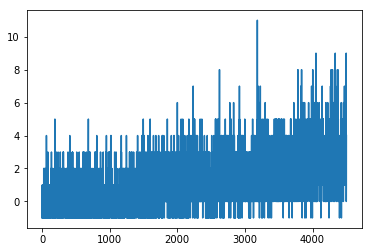

In [13]:
df = pd.DataFrame({"loss": loss_list, "reward": reward_list})

sns.lineplot(data=df["reward"])

Above plot is very hard to read, so below we take the moving average of the plot above.

Text(0.5, 1.0, 'training reward')

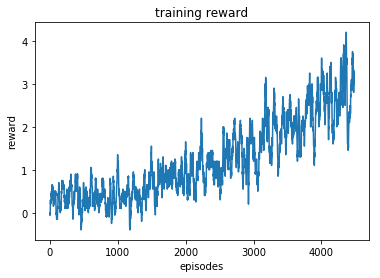

In [38]:
new_list = []
average_over = 20
for i in range(len(reward_list)):
    new_list.append(sum(reward_list[i:i+average_over])/average_over)

plt.plot(new_list[:-average_over])
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("training reward")